In [1]:
# Imports
import os, sys
import numpy as np
import uproot
import h5py
import matplotlib.pyplot as plt
import pprint
import mplhep as hep
plt.style.use(hep.style.CMS)

import uproot_methods

In [2]:
#Define a few variables
cols = ['#d55e00','#cc79a7','#0072b2','#f0e442','#009e73','#ef8a62','#67a9cf']

tree_name = 'Delphes'
jets      = 'JetPUPPIAK8'
nsubj_leaf = '{}.Tau[5]'.format(jets) #[0]=tau1,[1]=tau2,[2]=tau3,[3]=tau4,[4]=tau5
sd_leaf    = '{}.SoftDroppedJet'.format(jets)

cuts_m = {}
cuts_m['V'] = [65.,105.]
cuts_m['H'] = [105.,140.]
cuts_m['t'] = [105.,210.]

cuts_tau = {}
cuts_tau['V'] = 0.45
cuts_tau['H'] = 0.45
cuts_tau['t'] = 0.65

# Dataframe for all signals
dfs  = {}
# These are containers for TPR and TP using three different taggers: V/t/H tag. 
# E.g: TPR for W using V-tag   : tprs_Vtag['WW']
# E.g: TP for top using top tag: tprs_ttag['tt']
tprs_Vtag = {}
tprs_Htag = {}
tprs_ttag = {}
tps_Vtag  = {}
tps_Htag  = {}
tps_ttag  = {}

# Signal channels RSG->xx
signals = ['bb','gg','HH','qq','tt','WW','ZZ']

In [3]:
# Make the dataframes. TODO: Some 4-vectors seems to be all zero?  Check! 
for signal in signals:
  with uproot.open('/eos/project/d/dshep/CEVA/RSGraviton_{S}_NARROW_PU50_PF/RSGraviton_{S}_NARROW_PU50_PF_12.root'.format(S=signal)) as file:
    tree = file[tree_name]
    
    #Make dataframe
    dfs[signal] = tree.pandas.df(['{}.PT'.format(jets),'{}.Eta'.format(jets),'{}.Phi'.format(jets),nsubj_leaf, '{}*'.format(sd_leaf)])
    
    #Add tag variables
    mag2 = (uproot_methods.TLorentzVectorArray.from_cartesian(dfs[signal]['JetPUPPIAK8.SoftDroppedJet.fX'],dfs[signal]['JetPUPPIAK8.SoftDroppedJet.fY'],dfs[signal]['JetPUPPIAK8.SoftDroppedJet.fZ'],dfs[signal]['JetPUPPIAK8.SoftDroppedJet.fE'])).mag2
    softdropmass = (uproot_methods.TLorentzVectorArray.from_cartesian(dfs[signal]['JetPUPPIAK8.SoftDroppedJet.fX'],dfs[signal]['JetPUPPIAK8.SoftDroppedJet.fY'],dfs[signal]['JetPUPPIAK8.SoftDroppedJet.fZ'],dfs[signal]['JetPUPPIAK8.SoftDroppedJet.fE'])).mass
    dfs[signal]['sdmass'] = softdropmass
    dfs[signal]['sdmass'] = dfs[signal]['sdmass'].fillna(0)
    dfs[signal]['tau21']  = dfs[signal]['JetPUPPIAK8.Tau[5][1]']/dfs[signal]['JetPUPPIAK8.Tau[5][0]'] 
    dfs[signal]['tau21']  = dfs[signal]['tau21'].fillna(0)
    dfs[signal]['tau32']  = dfs[signal]['JetPUPPIAK8.Tau[5][2]']/dfs[signal]['JetPUPPIAK8.Tau[5][1]'] 
    dfs[signal]['tau32']  = dfs[signal]['tau32'].fillna(0)

/afs/cern.ch/user/t/thaarres/.local/lib/python3.6/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))


/afs/cern.ch/user/t/thaarres/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


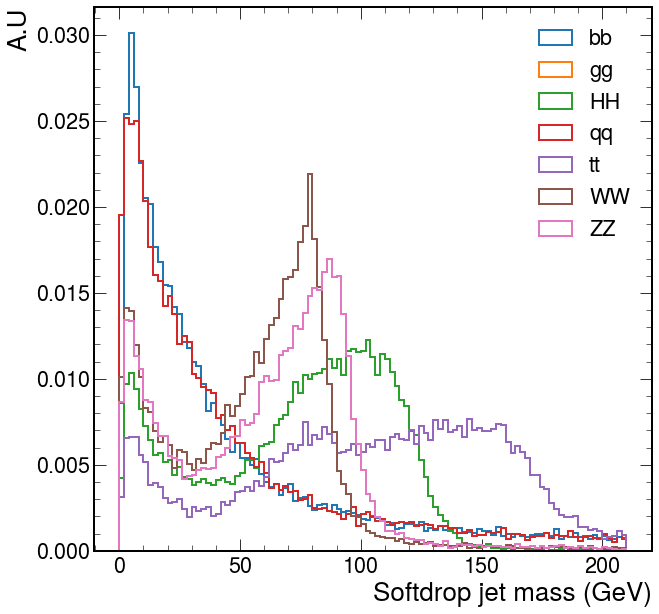

In [4]:
# Plot:
fig = plt.figure(figsize=(10,10))
for i,signal in enumerate(signals):
    #Distributions: Softdrop mass
    plt.hist(dfs[signal]['sdmass'], bins=105, range=(0,210),linewidth=2,facecolor=cols[i], density= True, histtype='step',label=r'{}'.format(signal))
    #Here the jet mass after a tau21 cut (notice almost all the low jet masses disappear)
#     plt.hist(dfs[signal]['sdmass'][dfs[signal].tau21 < cuts_tau['V'] ] , bins=60, range=(0,120),facecolor=cols[i],label=r'({}, after tagger cut)'.format(signal))
plt.xlabel('Softdrop jet mass (GeV)')
plt.ylabel('A.U')
plt.legend(loc='best',frameon=False)
plt.show()

/afs/cern.ch/user/t/thaarres/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/afs/cern.ch/user/t/thaarres/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
/afs/cern.ch/user/t/thaarres/.local/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


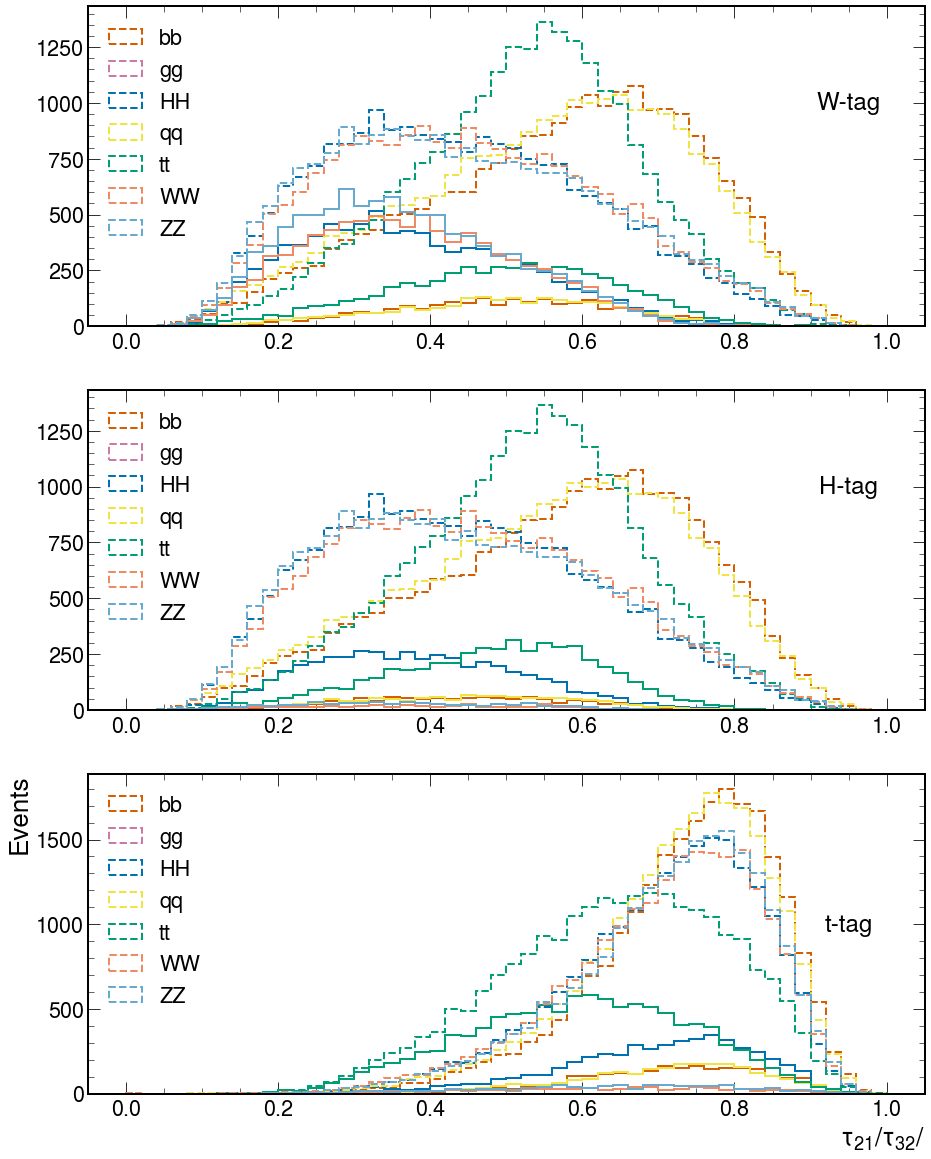

In [5]:
# Compute the TPRS/TPs

nbins = 50

fig, axs = plt.subplots(3,figsize=(15,20))

#precision(recall) = y:TP/TP+FP x=TPR 

for i,signal in enumerate(signals):

    n_den_Vtag, bins_den_Vtag, _ = axs[0].hist(dfs[signal]['tau21'], bins=nbins, range=(0,1),linestyle='dashed',linewidth=2,edgecolor=cols[i], histtype='step',label=r'{}'.format(signal))
    n_num_Vtag, bins_num_Vtag, _ = axs[0].hist(dfs[signal]['tau21'][ (dfs[signal].sdmass > cuts_m['V'][0]) & (dfs[signal].sdmass < cuts_m['V'][1])], bins=nbins, range=(0,1),linewidth=2,edgecolor=cols[i], histtype='step')  

    n_den_Htag, bins_den_Htag, _ = axs[1].hist(dfs[signal]['tau21'], bins=nbins, range=(0,1),linestyle='dashed',linewidth=2,edgecolor=cols[i], histtype='step',label=r'{}'.format(signal))
    n_num_Htag, bins_num_Htag, _ = axs[1].hist(dfs[signal]['tau21'][ (dfs[signal].sdmass > cuts_m['H'][0]) & (dfs[signal].sdmass < cuts_m['H'][1])], bins=nbins, range=(0,1),linewidth=2,edgecolor=cols[i], histtype='step')  

    n_den_ttag, bins_den_ttag, _ = axs[2].hist(dfs[signal]['tau32'], bins=nbins, range=(0,1),linestyle='dashed',linewidth=2,edgecolor=cols[i], histtype='step',label=r'{}'.format(signal))
    n_num_ttag, bins_num_ttag, _ = axs[2].hist(dfs[signal]['tau32'][ (dfs[signal].sdmass > cuts_m['t'][0]) & (dfs[signal].sdmass < cuts_m['t'][1])], bins=nbins, range=(0,1),linewidth=2,edgecolor=cols[i], histtype='step')  

    #To plot a ROC curve, we need to compute the yield of events passing a given cut on the tau tagger, scanning tau tagger from 1-0. 
    #We loop over the bins of the numerator histogram and compute pass/all
    # sum over number of events in each bin, total histogram for the denominator
    tprs_V = []
    tps_V  = []
    tprs_H = []
    tps_H  = []
    tprs_t = []
    tps_t  = []
    den_V = sum(n_den_Vtag[0:nbins])
    den_H = sum(n_den_Htag[0:nbins])
    den_t = sum(n_den_ttag[0:nbins])
    for bin in range(nbins):
        tprV = sum(n_num_Vtag[0:50-bin])/den_V
        tpV  = sum(n_num_Vtag[0:50-bin])
        tprs_V.append(tprV)
        tps_V.append(tpV)
        
        tprH = sum(n_num_Htag[0:50-bin])/den_H
        tpH  = sum(n_num_Htag[0:50-bin])
        tprs_H.append(tprH)
        tps_H.append(tpH)
        
        tprt = sum(n_num_ttag[0:50-bin])/den_t
        tpt  = sum(n_num_ttag[0:50-bin])
        tprs_t.append(tprt)
        tps_t.append(tpt)
        
    tprs_Vtag[signal] = tprs_V
    tps_Vtag [signal] = tps_V
    tprs_Htag[signal] = tprs_H
    tps_Htag [signal] = tps_H
    tprs_ttag[signal] = tprs_t
    tps_ttag [signal] = tps_t
    
plt.xlabel(r'$\tau_{21}$/$\tau_{32}$/')
plt.ylabel('Events')
axs[0].text(0.95, 1000., 'W-tag', size=24, ha='center', va='center')
axs[1].text(0.95, 1000., 'H-tag', size=24, ha='center', va='center')
axs[2].text(0.95, 1000., 't-tag', size=24, ha='center', va='center')
axs[0].legend(loc='upper left',frameon=False)
axs[1].legend(loc='upper left',frameon=False)
axs[2].legend(loc='upper left',frameon=False)
plt.show()



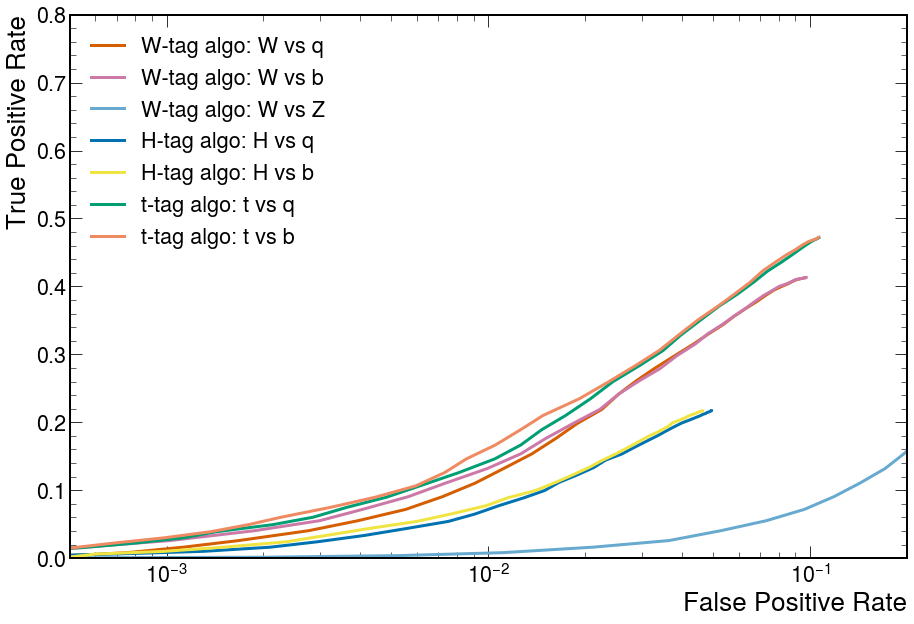

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


In [6]:
#Make some ROCs for fun
fig = plt.figure(figsize=(15,10))
plt.plot(tprs_Vtag['qq'], tprs_Vtag['WW'], label='W-tag algo: W vs q',c=cols[0],linewidth=3)
plt.plot(tprs_Vtag['bb'], tprs_Vtag['WW'], label='W-tag algo: W vs b',c=cols[1],linewidth=3)
plt.plot(tprs_Vtag['ZZ'], tprs_Vtag['WW'], label='W-tag algo: W vs Z',c=cols[6],linewidth=3)
plt.plot(tprs_Htag['qq'], tprs_Htag['HH'], label='H-tag algo: H vs q',c=cols[2],linewidth=3)
plt.plot(tprs_Htag['bb'], tprs_Htag['HH'], label='H-tag algo: H vs b',c=cols[3],linewidth=3)
plt.plot(tprs_ttag['qq'], tprs_ttag['tt'], label='t-tag algo: t vs q',c=cols[4],linewidth=3)
plt.plot(tprs_ttag['bb'], tprs_ttag['tt'], label='t-tag algo: t vs b',c=cols[5],linewidth=3)

plt.semilogx()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.xlim(0.0005,0.2)
plt.ylim(0.0,0.8)
plt.legend(loc='best',frameon=False)
plt.show()
fig.tight_layout()
fig.savefig('roc_all.pdf')
